## Knowledge-based LiDAR Feature Extraction

This notebook will show how this simple knowledge-based solution to extract meaningful features such as building, tree, water, and ground by using LiDAR data only.

The workflow of the knowledge-based solution consists of the following steps:

(1) Convert point data to classification array based on the provided classification information.

(2) Calculate the height above ground (HAG) from point data in order to differentiate trees from buildings and other infrastructures.

(3) Knowledge-based feature extraction.

(4) Remove noise using a majority filter.

<img src="pictures/knowledgebased_workflow.png" width="100%" />

## Important Setup

This notebook depends on some external modules. Please make sure to following the instructions in README.md to set up the conda environment and activate it before launching this notebook. A sample LiDAR dataset [C_37EZ1_7415_sample.las](data/knowledgebase/C_37EZ1_7415_sample.las) is provided for this notebook. 

## Required Modules

In [1]:
# external modules
import laspy
import glob
import os
import numpy as np
import pdal
from osgeo import gdal
import skimage.io

# customized modules
from lidar2feature import utils, knowledgebase

In [2]:
# ploting 
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('seaborn-notebook')

## Data
A sample LiDAR dataset [C_37EZ1_7415_sample.las](data/knowledgebase/C_37EZ1_7415_sample.las) is provided for this notebook. You can run this notebook on other `.las` datasets by changing the `las_name` below. 

In [3]:
# the name of the processing data
las_name = 'C_37EZ1_7415_sample.las'

# the file path for the input data and prefix
data_dir = './data/knowledgebase/'
os.makedirs(data_dir, exist_ok=True)
input_las_path = data_dir + las_name
las_prefix = data_dir + os.path.splitext(las_name)[0]

# the file paths for intermedia files
class_tif_path = las_prefix + '_class.tif'
hag_tif_path = las_prefix + '_hag.tif'
intensity_tif_path = las_prefix + '_intensity.tif'

# the file path for the final result
result_tif_path = las_prefix + '_result.tif'

## 1. Convert point data to classification array based on the provided classification information

In [4]:
# convert LAS to provided classification raster
utils.las_to_tif(input_las_path, class_tif_path, dimension="classification", datatype='int16', resolution=1)

# read the classification raster as array
class_array = utils.read_tif(class_tif_path)

Coverted the point cloud to a raster with built-in classification information ...


## 2. Calculate the height above ground (HAG) from point data in order to differentiate trees from buildings and other infrastructures

In [5]:
# convert LAS to height above ground (HAG) raster
utils.las_to_hag(input_las_path, hag_tif_path, resolution=1)

# read the height above ground (HAG) raster as array
hag_array = utils.read_tif(hag_tif_path)

# assure both arrays (class_array and hag_array) should have the same dimension
assert class_array.shape == hag_array.shape, "Both classification and height arrays above ground should have the same dimension"

Generated the heigh above ground raster...


## 3. Knowledge-based feature extraction

This part include three components: (1) recode the classes; (2) extract water; and (3) identify trees as shown below.

* **Recode the classes** based on the provided classification information.
```
  |  *** Provided Classes ***   |    | *** Targeted Classes  |
  | 6                           | -> |  1: building          |
  | 4, 5                        | -> |  2: tree              |
  | 9                           | -> |  3: water             |
  | 11                          | -> |  4: road              |
  | 10, 13-17                   | -> |  5: infrastructure    |
  | 2, 3                        | -> |  6: ground            |
  | 0, 1, 7, 8, 12, 18, 19, 19+ | -> |  7: other             |
```

* **Extract water**: Change non-return (-9,999) to water-3 because water does not have any return points.

* **Identify trees**: Differentiate trees from buildings and other infrastructures by assuming that trees are taller than 1 m but were not originally classified as building-1 and infrastructure-5.

In [6]:
# recode and execute knowledge-based classification
tree_height_threshold = 1
result_arary = knowledgebase.classification(class_array, hag_array, tree_height_threshold)

# export the classified result
utils.save_tif(class_tif_path, result_arary, result_tif_path)

Saved the image at ./data/knowledgebase/C_37EZ1_7415_sample_result.tif


## 4. Remove noise using a majority filter
To reduce reduce salt-and-pepper effects using a majority filter

In [7]:
# set the sliding window size. 
# noet: the large the size is the smoother the result will be. 
sliding_window_size = 3
result_arary = utils.majority_filter(result_arary, sliding_window_size)

# export the final filtered result
utils.save_tif(class_tif_path, result_arary, result_tif_path)

Filterd the noise using a majority filter with a size of 3 majority filter
Saved the image at ./data/knowledgebase/C_37EZ1_7415_sample_result.tif


## Visualize the input and output
The left image is what intensity image and the one on the right is the final result.

Coverted the point cloud to a raster with built-in classification information ...


C:\Users\WEI-HO~1\AppData\Local\Temp/ipykernel_2448/2731493149.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


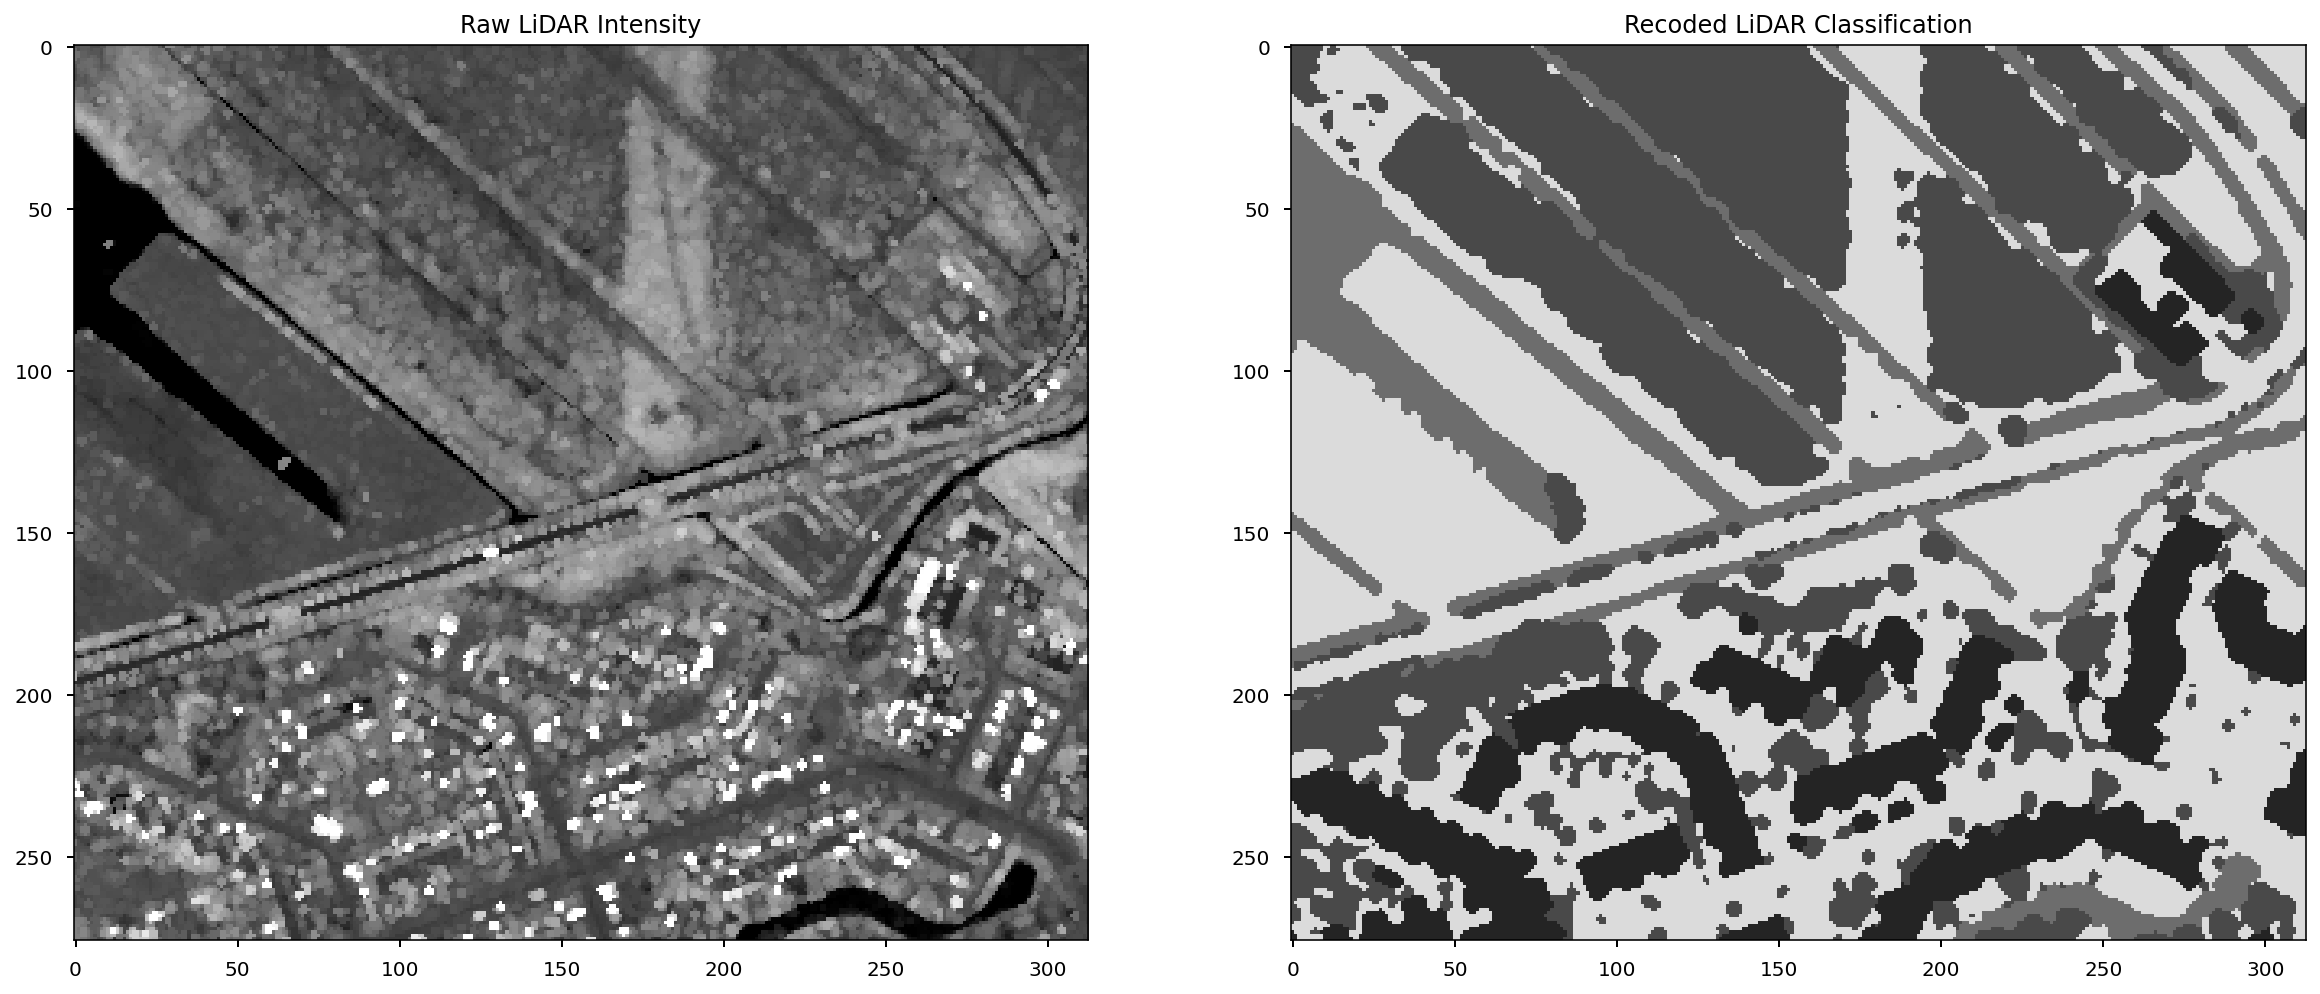

In [8]:
# for visualization
utils.las_to_tif(input_las_path, intensity_tif_path, dimension="intensity", datatype="float", resolution=1)
original = skimage.io.imread(intensity_tif_path)

# plot
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(original, cmap='gray', vmin=0, vmax=1000)
ax[0].set_title('Raw LiDAR Intensity')
ax[1].imshow(result_arary, cmap='gray', vmin=0, vmax=7)
ax[1].set_title('Recoded LiDAR Classification')
fig.show()

## Final result file

In [9]:
print("The final result is at: ", result_tif_path)

The final result is at:  ./data/knowledgebase/C_37EZ1_7415_sample_result.tif
